# Detection Efficiency Filter Demo

This notebook demonstrates the detection efficiency/fading function filter. The equation for the fading function is taken from Veres & Chesley (2017):

$$
\epsilon(m) = \frac{F}{1 + e^\frac{m-m_{5\sigma}}{w}}
$$

where $\epsilon(m)$ is the probability of detection, $F$ is the peak detection efficiency, $m$ and $m_{5\sigma}$ are respectively the observed magnitude and $5\sigma$ limiting magnitude of the pointing, and $w$ is the width of the fading function.

In [1]:
from sorcha.modules.PPFadingFunctionFilter import PPFadingFunctionFilter
from sorcha.modules.PPModuleRNG import PerModuleRNG

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Create a dataframe of synthetic observations

Only the apparent magnitude and the five-sigma limiting depth are needed for this. For simplicity, we will set the five-sigma limiting depth to be constant for all observations.

In [3]:
nobs_per_field = 1000000

In [4]:
mags = np.random.uniform(23.0, 26.0, nobs_per_field)
five_sigma = np.zeros(nobs_per_field) + 24.5
random_obs = pd.DataFrame({"PSFMag":mags, "fiveSigmaDepth_mag":five_sigma})

In [5]:
random_obs

,PSFMag,fiveSigmaDepth_mag
0,25.221313,24.5
1,23.714762,24.5
2,23.481671,24.5
3,24.948002,24.5
4,25.125996,24.5
...,...,...
999995,24.675934,24.5
999996,24.919128,24.5
999997,24.956026,24.5
999998,24.704690,24.5


We can apply the fading function filter implementation in Sorcha to the randomised observations.

In [6]:
peak_efficiency = 1.0
width = 0.1
rng=PerModuleRNG(2021)
reduced_obs = PPFadingFunctionFilter(random_obs, peak_efficiency, width, rng)

Now we calculate the probabilty of each observation to survive Sorcha's fading function filter, binned by magnitude.

In [7]:
bin_width = 0.04
magbins = np.arange(23.0, 26.0, bin_width)

magcounts, _ = np.histogram(random_obs['PSFMag'].values, bins=magbins)

redmagcounts, _ = np.histogram(reduced_obs['PSFMag'].values, bins=magbins)

sorcha_probability = redmagcounts/magcounts

And we can compare this to the calculated detection probability of each magnitude bin, using Equation One.

In [8]:
calculated_probability = peak_efficiency / (1.0 + np.exp((magbins - 24.5) / width))

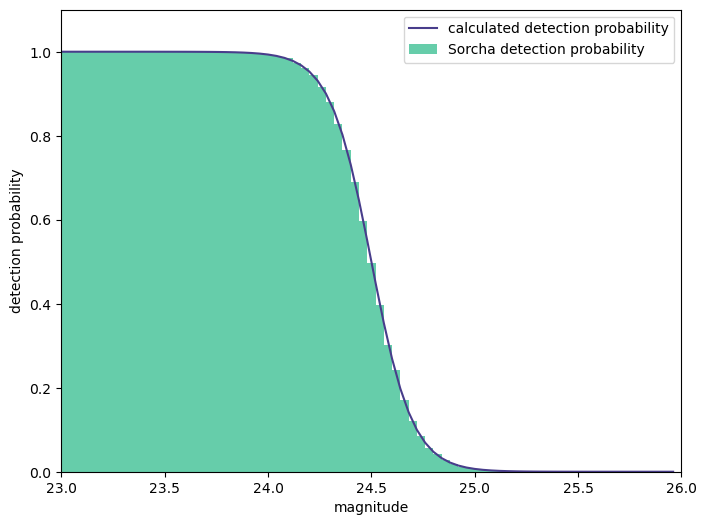

In [9]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.bar(magbins[:-1], sorcha_probability, align="edge", width=bin_width, color="mediumaquamarine", label="Sorcha detection probability")
ax.set_ylim((0, 1.1))
ax.set_xlim((23, 26)) 
ax.set_xlabel("magnitude")
ax.set_ylabel("detection probability")
ax.plot(magbins, calculated_probability, color="darkslateblue", label="calculated detection probability")
ax.legend()

Sorcha's detection probability clearly follows the expected curve.

We can also take a look at how the fading function/detection efficiency changes with parameters.

In [10]:
def deteff(mags, fivesig, peak, width):
    return peak / (1.0 + np.exp((mags - fivesig) / width))

In [11]:
colors = plt.get_cmap('gnuplot', 3)
x = colors(np.arange(0,3,1))

In [12]:
widths = [0.05, 0.1, 0.15]
colors = ["tomato", "darkslateblue", "mediumturquoise"]
styles = ["solid", "dotted", "dashed"]

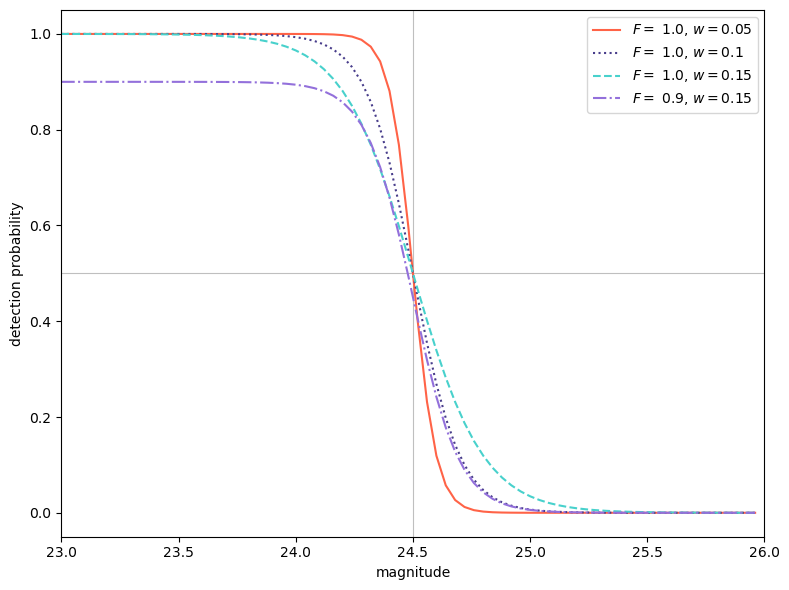

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.axvline(24.5, 0, 1, linestyle="-", alpha=0.5, color="grey", linewidth=0.8)
ax.axhline(0.5, 0, 1, linestyle="-", alpha=0.5, color="grey", linewidth=0.8)

for i, width in enumerate(widths):
    y = deteff(magbins, 24.5, 1., width)
    ax.plot(magbins, y, color=colors[i], linestyle=styles[i], label=f"$F = $ 1.0, $w = {width}$")

y = deteff(magbins, 24.5, .9, 0.1)
ax.plot(magbins, y, color="mediumpurple", linestyle="dashdot", label=f"$F = $ 0.9, $w = {width}$")

ax.set_xlim((23, 26))
ax.legend()
ax.set_xlabel("magnitude")
ax.set_ylabel("detection probability")

fig.tight_layout()